In [ ]:
#load library

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tcn import TCN # main library
import math
from sklearn.preprocessing import RobustScaler
#from keras.initializers import  glorot_normal, RandomUniform
#from keras import optimizers,regularizers

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model 
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
#load data

In [2]:
df = pd.read_csv("london_merged.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.set_index("timestamp")
#df.head()

df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

training_data_len = math.ceil(len(df) * 0.9) # taking 90% of data to train and 10% of data to test
testing_data_len = len(df) - training_data_len

time_steps = 24
train, test = df.iloc[0:training_data_len], df.iloc[(training_data_len-time_steps):len(df)]
print(df.shape, train.shape, test.shape)

(17414, 13) (15673, 13) (1765, 13)


In [4]:
train_trans = train[['t1','t2', 'hum', 'wind_speed']].to_numpy()
test_trans = test[['t1','t2', 'hum', 'wind_speed']].to_numpy()

scaler = RobustScaler() # Handles outliers
train.loc[:, ['t1','t2','hum', 'wind_speed']]=scaler.fit_transform(train_trans)
test.loc[:, ['t1','t2', 'hum', 'wind_speed']]=scaler.fit_transform(test_trans)

train['cnt'] = scaler.fit_transform(train[['cnt']])
test['cnt'] = scaler.fit_transform(test[['cnt']])

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [5]:
from tqdm import tqdm_notebook as tqdm

#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in tqdm(range(len(train) - time_steps)):
    x_train.append(train.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    y_train.append(train.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

#Create the x_test and y_test data sets
x_test = []
y_test = df.loc[:,'cnt'].iloc[training_data_len:len(df)]

for i in tqdm(range(len(test) - time_steps)):
    x_test.append(test.drop(columns='cnt').iloc[i:i + time_steps].to_numpy())
    # y_test.append(test.loc[:,'cnt'].iloc[i + time_steps])

#Convert x_test and y_test to numpy arrays
x_test = np.array(x_test)
y_test = np.array(y_test)

# All 12 columns of the data
print('Train size:')
print(x_train.shape, y_train.shape)
print('Test size:')
print(x_test.shape, y_test.shape)

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/15649 [00:00<?, ?it/s]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1741 [00:00<?, ?it/s]

Train size:
(15649, 24, 12) (15649,)
Test size:
(1741, 24, 12) (1741,)


In [ ]:
#Model Training

In [25]:
#init = glorot_normal(seed=None) # 給 LSTM
#init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer
#nadam = optimizers.Nadam(lr=0.002,clipvalue=0.5)
from tensorflow.keras.initializers import RandomUniform
init_d = RandomUniform(minval=-0.05, maxval=0.05) # 給 Dense layer
model = Sequential()
model.add(TCN(input_shape=(x_train.shape[1],x_train.shape[2]),
        kernel_size=3,
        nb_filters=80,
        nb_stacks=1,
        dilations=(1, 2, 4, 8),
        kernel_initializer='glorot_uniform',
        use_skip_connections=True,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=True,
        dropout_rate = 0.05,
        return_sequences=True
        ))
model.add(Dropout(0.5))
model.add(TCN(
        kernel_size=3,
        nb_filters=80,
        nb_stacks=1,
        dilations=(1, 2, 4, 8),
        kernel_initializer='glorot_uniform',
        use_skip_connections=True,
        use_batch_norm=False,
        use_weight_norm=False,
        use_layer_norm=True,
        dropout_rate = 0.05,
        return_sequences=False
        ))  
model.add(Dropout(0.3))
model.add(Dense(1,kernel_initializer=init_d))  
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_18 (TCN)                 (None, 24, 80)            140240    
_________________________________________________________________
dropout_18 (Dropout)         (None, 24, 80)            0         
_________________________________________________________________
tcn_19 (TCN)                 (None, 80)                155520    
_________________________________________________________________
dropout_19 (Dropout)         (None, 80)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 81        
Total params: 295,841
Trainable params: 295,841
Non-trainable params: 0
_________________________________________________________________


In [ ]:

# def solve_cudnn_error():
#     gpus = tf.config.experimental.list_physical_devices('GPU')
#     if gpus:
#         try:
#             # Currently, memory growth needs to be the same across GPUs
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
#             logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#             print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#         except RuntimeError as e:
#             # Memory growth must be set before GPUs have been initialized
#             print(e)
# solve_cudnn_error()

In [26]:
print('Train...')
model.compile(optimizer = "nadam" , loss="mse")
history = model.fit(x_train, y_train, epochs=120, batch_size=12, validation_split=0.1, shuffle=True)
#Save Model
model.save('TCN_model_1.h5')  # creates a HDF5 file 
del model

Train...
Train on 14084 samples, validate on 1565 samples
Epoch 1/120
14084/14084 [==============================] - 33s 2ms/sample - loss: 0.1980 - val_loss: 0.2528
Epoch 2/120
14084/14084 [==============================] - 26s 2ms/sample - loss: 0.0908 - val_loss: 0.0746
Epoch 3/120
14084/14084 [==============================] - 26s 2ms/sample - loss: 0.0773 - val_loss: 0.0664
Epoch 4/120
14084/14084 [==============================] - 26s 2ms/sample - loss: 0.0681 - val_loss: 0.0748
Epoch 5/120
14084/14084 [==============================] - 26s 2ms/sample - loss: 0.0615 - val_loss: 0.0575
Epoch 6/120
14084/14084 [==============================] - 26s 2ms/sample - loss: 0.0592 - val_loss: 0.0605
Epoch 7/120
14084/14084 [==============================] - 23s 2ms/sample - loss: 0.0543 - val_loss: 0.0590
Epoch 8/120
14084/14084 [==============================] - 21s 1ms/sample - loss: 0.0513 - val_loss: 0.1322
Epoch 9/120
14084/14084 [==============================] - 20s 1ms/sample - lo

Load Success
Predict time:  1.035651683807373
RMSE:  1332.839437035456
R-square:  -1.0575572923840113
Adj R-square:  -1.0575572923840113


Text(0, 0.5, 'mse score')

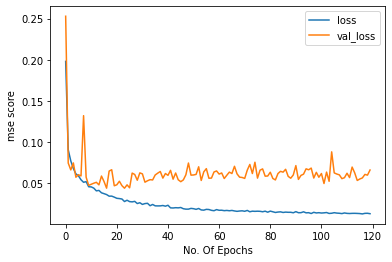

In [27]:
from tensorflow.keras.utils import plot_model
custom_ob = {'TCN': TCN}
# model = load_model('TCN_model_1.h5', custom_objects=custom_ob)
model = load_model('TCN_model_1.h5', custom_objects=custom_ob)
print('Load Success')
# plot_model(
#     model, to_file='model.png', show_shapes=True,
#     show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
# )

import time
t1 = time.time()
y_pred = model.predict(x_test)
t2 = time.time()
print('Predict time: ',t2-t1)
y_pred = scaler.inverse_transform(y_pred)#Undo scaling

from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: ',rmse_lstm)

r2 =  r2_score(y_test, y_pred)
print('R-square: ',r2)

n = len(y_test)
p = 12
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('Adj R-square: ',r2)

plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.legend()